In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
from mp_api.client import MPRester
from pymatgen.core.operations import SymmOp
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.phonon.plotter import PhononBSPlotter
from jupyter_jsmol.pymatgen import quick_view
from pymatgen.analysis.diffraction.xrd import *
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
mp_key = "nPJf5FFhl6DXPpC4NQSxAL5REFwR0nb0" #C'est le clé api de materials project personnel
mp_id = "mp-23040"

In [3]:
with MPRester(mp_key) as m:
    #Structure du matériau
    struct = m.get_structure_by_material_id(mp_id) 
    struct_prim = m.get_structure_by_material_id(mp_id)
    conv_struct = SpacegroupAnalyzer(struct_prim).get_conventional_standard_structure()
    
    ops_sym = SpacegroupAnalyzer(conv_struct).get_space_group_operations() #Symétries
    
    el_bs = m.get_bandstructure_by_material_id(mp_id) #Bandes électroniques
    el_dos = m.get_dos_by_material_id(mp_id) #Densité électronique
    
    analyse = SpacegroupAnalyzer(struct) #Analyseur


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

# Analyse des bandes électroniques du $Ca_{2}PI$

{'direct': False, 'energy': 1.6997000000000004, 'transition': '\\Gamma-F'}


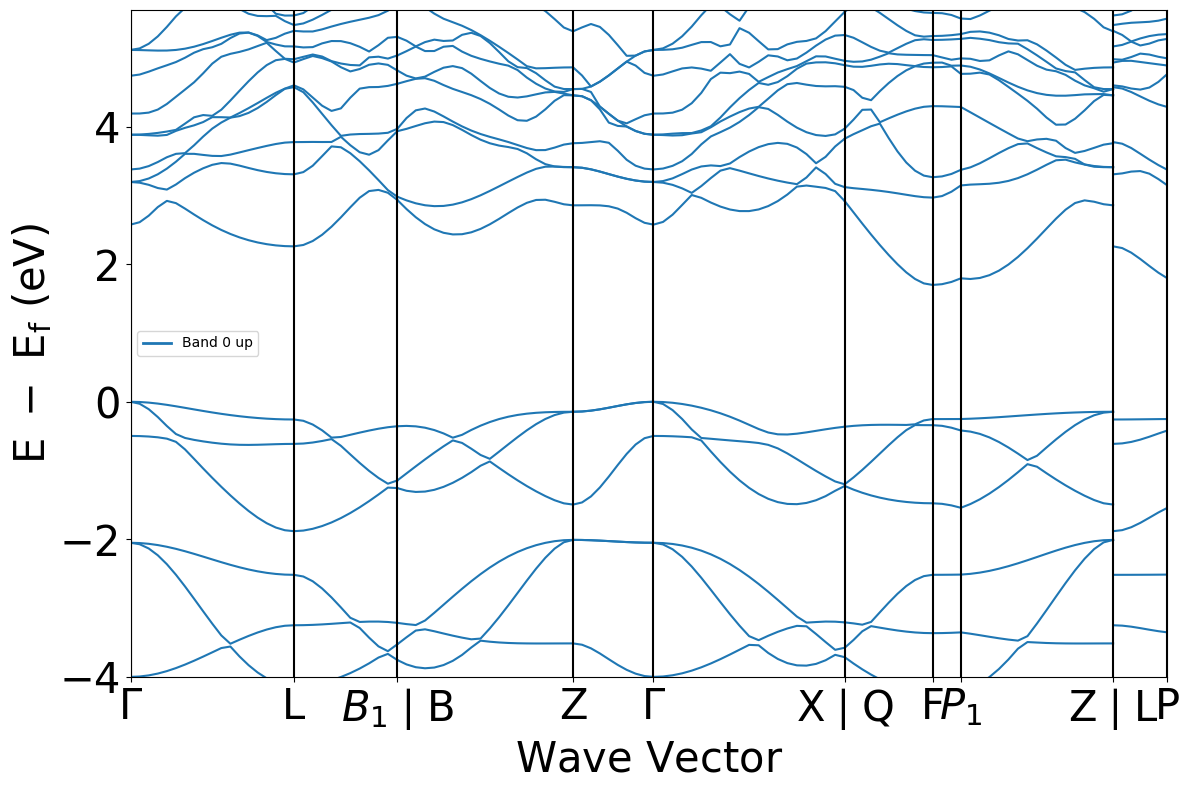

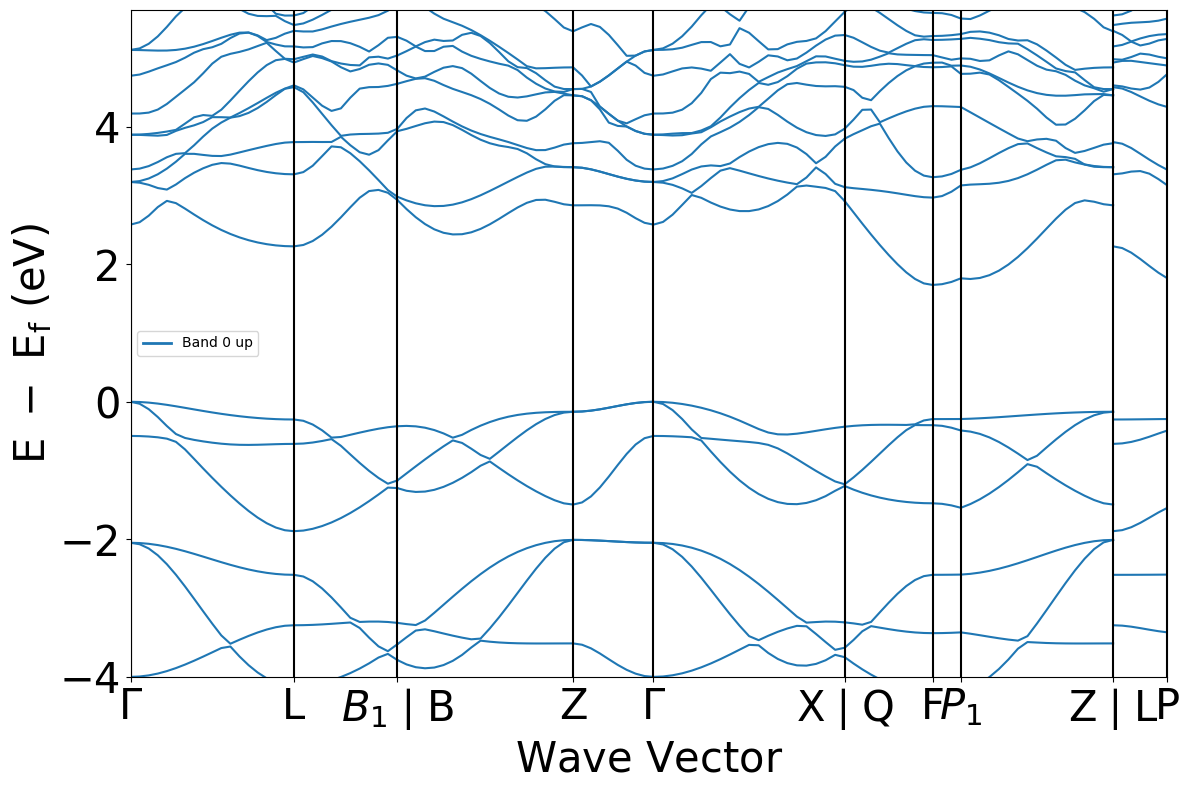

In [5]:
gap = el_bs.get_band_gap()
print(gap)

#plot_el_bs = get_plot_bs(el_bs) #Contient trop d'infos
plot_el_bs = BSPlotter(el_bs)
plot_el_bs.show()

#plot_el_dos = get_plot_bs(el_bs) #Contient trop d'infos
plot_el_dos = BSPlotter(el_bs)
plot_el_dos.show()

### Bande interdite

La bande interdite du matériau est: indirect 

L'épaisseur de la bande interdite en [eV]:  1.6997000000000004 

La vecteur d'onde de transition: \Gamma-F 

Illustration de la bande interdit:


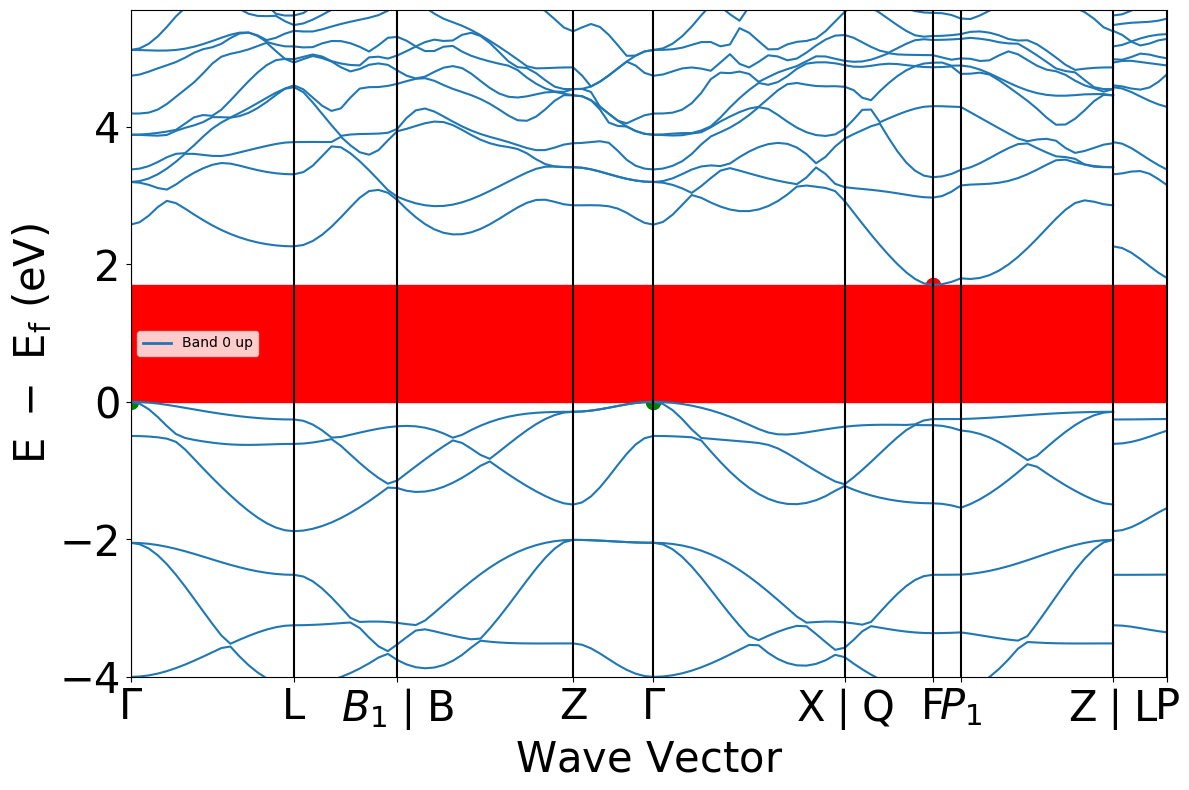

In [6]:
data = plot_el_bs.bs_plot_data()
#print(data)

gap_type = "indirect"
if gap.get('direct'):
    gap_type = "direct"

print("La bande interdite du matériau est:", gap_type, "\n")
print("L'épaisseur de la bande interdite en [eV]: ", gap['energy'], "\n")
print("La vecteur d'onde de transition:", gap['transition'], "\n")

distance = data.get('ticks').get('distance')
print("Illustration de la bande interdit:")

plot_el_bs.get_plot(vbm_cbm_marker=True) #Pour afficher points de départ, fin des vecteurs de transition
plt.fill_between([distance[0],distance[len(distance)-1]], 0, gap['energy'], color = "red")

Conclusion:

L'énérgie minimal à fournir à une électron pour permettre la transition d'un électron de la bande de valence à la bande de conduction est 1.16997 [eV]. Cet transition faite sauter l'électron de la bande localisé près d'un noyau atomique à une commune au cristal permettant la circulation libre.

On voit que cet énergie de transition est supérieur à 1 [eV], mais inférieur à 5 [eV], donc cet matériau est entre les semiconducteurs et isolants électriques.

La transition est indirect donc el peut se passer pour plusieurs vecteurs d'onde k.

### Dispersion

Objectif:
"trouver la direction dans laquelle la dernière (première) bande de valence (conduction) présente le plus et le moins de dispersion (insérer une figure indiquant la dispersion par des flèches)"

In [7]:
data = plot_el_bs.bs_plot_data()
distances = data.get('distances') 
energies = data.get('energy').get('1') #get '1' car c'est une dictionnaire pour qq raison
#print(distances)
#print(energies) #elements de energies: une bande d'energie a travers les vecteurs d'onde k
dist = data.get('ticks').get('distance') #il existe des valeurs répétées plusieurs fois
dist = [dist[0],dist[1],dist[3],dist[4],dist[6],dist[8],dist[9],dist[11],dist[13],dist[14]]
#éléments uniques: 0,1,3,4,6,8,9,11,13,14

#Bande interdit situé entre les bandes:
#   bandes = get_plot_bs(el_bs)
#   bandes.show()
# ==> 
#dernier BV: 16 => id=15
#premier BC: 17 => id=16
#Pas oublier de soustraire 1 de l'indice des bandes en python!!!

##### Calcul de pentes min et max

In [8]:
#Valeurs et endroits de pente maximale et minimale (max et min dispersions)
pente_max_BV = 0     ; id_max_BV = 0
pente_min_BV = np.inf; id_min_BV = 0


pente = 0; dE = 0; dk = 0

#Calcul pentes éléments succéssives pour bande de valence
for i in range(len(distances)):
    lenk = len(distances[i]) - 1 #points de donnees sur ce segment
    lenE = len(energies[i][15]) - 1 #points de donnees sur ce segment
    
    dE = energies[i][15][lenE] - energies[i][15][0] #difference en E total sur le segment
    dk = distances[i][lenk] - distances[i][0] #difference de vecteur d'onde k total sur le segment
    
    pente = dE / dk
    
    if abs(pente) > abs(pente_max_BV):   #Si nouvel max
        pente_max_BV = pente; id_max_BV = i; dk_max_BV = dk; dE_max_BV = dE
    elif abs(pente) < abs(pente_min_BV): #Si nouvel min
        pente_min_BV = pente; id_min_BV = i; dk_min_BV = dk; dE_min_BV = dE

        
#print(pente_min_BV, ", ", id_min) #marche
#print(pente_max_BV, ", ", id_max) #fixé

In [9]:
#Valeurs et endroits de pente maximale et minimale (max et min dispersions)
pente_max_BC = 0     ; id_max_BC = 0
pente_min_BC = np.inf; id_min_BC = 0
dk_max_BC = 0; dE_max_BC = 0
dk_min_BC = 0; dE_min_BC = 0

pente = 0; dE = 0; dk = 0

#Calcul pentes éléments succéssives pour bande de conduction
for i in range(len(distances)):
    lenk = len(distances[i]) - 1 #points de donnees sur ce segment
    lenE = len(energies[i][16]) - 1 #points de donnees sur ce segment
    
    dE = energies[i][16][lenE] - energies[i][16][0] #difference en E total sur le segment
    dk = distances[i][lenk] - distances[i][0] #difference de vecteur d'onde k total sur le segment
    
    pente = dE / dk
    
    if abs(pente) > abs(pente_max_BC):   #Si nouvel max
        pente_max_BC = pente; id_max_BC = i; dk_max_BC = dk; dE_max_BC = dE
    elif abs(pente) < abs(pente_min_BC): #Si nouvel min
        pente_min_BC = pente; id_min_BC = i; dk_min_BC = dk; dE_min_BC = dE

        
#print(pente_min_BC, ", ", id_min) #marche
#print(pente_max_BC, ", ", id_max) #marche

In [10]:
print("Valeur minimale de la dispersion sur la première bande de conduction", pente_min_BC, "[eV]")
#print(id_min_BC) # sur le segment B - Z
print(", sur le segment B - Z", "\n")

print("Valeur maximale de la dispersion sur la première bande de conduction", pente_max_BC, "[eV]")
#print(id_max_BC) # sur le segment Q - F
print(", sur le segment Q - F", "\n")


print("Valeur minimale de la dispersion sur la première bande de valence", pente_min_BV, "[eV]")
#print(id_min_BV) # sur le segment F - P1
print(", sur le segment F - P1", "\n")

print("Valeur maximale de la dispersion sur la première bande de valence", pente_max_BV, "[eV]")
#print(id_max_BV) # sur le segment Gamma - X
print(", sur le segment Gamma - X", "\n")

Valeur minimale de la dispersion sur la première bande de conduction -0.08550134545638476 [eV]
, sur le segment B - Z 

Valeur maximale de la dispersion sur la première bande de conduction -2.6569674029448165 [eV]
, sur le segment Q - F 

Valeur minimale de la dispersion sur la première bande de valence 0.00610694810161012 [eV]
, sur le segment F - P1 

Valeur maximale de la dispersion sur la première bande de valence -0.36310123903471747 [eV]
, sur le segment Gamma - X 



##### Création figure

La flèche rouge indique la dispersion minimale de la dernière bande de valence
La flèche verte indique la dispersion maximale de la dernière bande de valence
La flèche magenta indique la dispersion minimale de la première bande de conduction
La flèche noire indique la dispersion maximale de la première bande de conduction


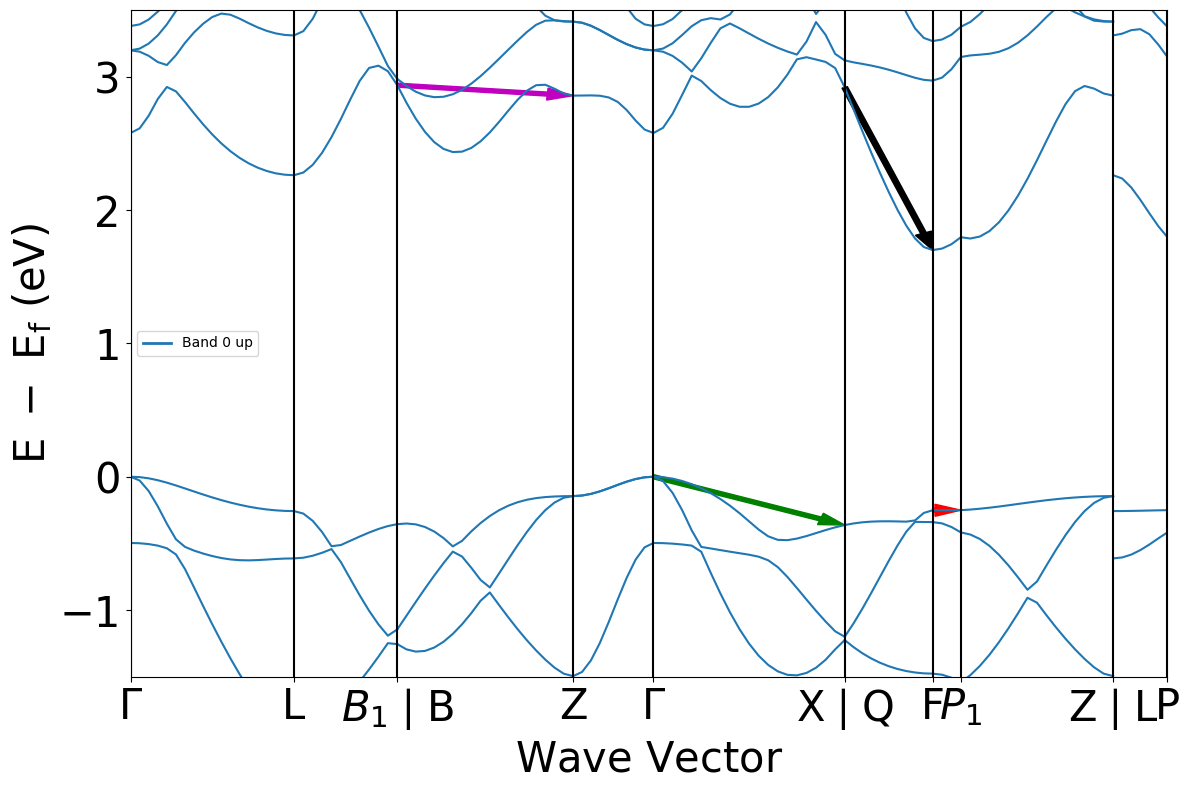

In [11]:
plot_el_bs.get_plot(ylim = (-1.5, 3.5)) #Emin, Emax du graphe

#Structure des plots arrow:
#   en partant de quel segment, en partant de quel niveau d'energie, dk, dE, arguments extra

# length_includes_head=True nécessaire pour fixer fin des flèches

plt.arrow(dist[id_min_BV], energies[id_min_BV][15][0], dk_min_BV, dE_min_BV, color = 'r', width = 0.03, length_includes_head=True)
plt.arrow(dist[id_max_BV], energies[id_max_BV][15][0], dk_max_BV, dE_max_BV, color = 'g', width = 0.03, length_includes_head=True)

plt.arrow(dist[id_min_BC], energies[id_min_BC][16][0], dk_min_BC, dE_min_BC, color = 'm', width = 0.03, length_includes_head=True)
plt.arrow(dist[id_max_BC], energies[id_max_BC][16][0], dk_max_BC, dE_max_BC, color = 'k', width = 0.03, length_includes_head=True)


print("La flèche rouge indique la dispersion minimale de la dernière bande de valence")
print("La flèche verte indique la dispersion maximale de la dernière bande de valence")

print("La flèche magenta indique la dispersion minimale de la première bande de conduction")
print("La flèche noire indique la dispersion maximale de la première bande de conduction")

La disperison sur une bande électronique corresponds à la variation d'énergie des électrons en fonction de leur vecteur d'onde avec une pente plus extréme signifiant une dispersion plus élevée.

Le matériau n'est pas isotrope car la dispersion n'est pas identique dans toutes les directions, donc la mobilité des électrons n'est aussi pas égal dans toutes les directions dans ce cristal avec une conductivité supérieur dans la direction des forts dispersions (pentes forts) et inférieur dans la direction des faibles dispersions (pentes faibles).

### Masse effective

Objectif: "calculer la masse effective au sommet (base) de la dernière (première) bande de valence (conduction) en supposant une dispersion parabolique."

La masse effective est obtenu par approximation de dispersion parabolique avec les formules suivantes:
$E(k) = \frac{\hbar^2\cdot k^2}{2 \cdot m^\ast }$
,donc masse effective étant:
$m^\ast = \frac{\hbar^2\cdot k^2}{2\cdot E(k)}$

Ou, en supposant que le cristal est isotrope: $m^\ast = \frac{\hbar^2}{\frac{\partial^2 \varepsilon}{\partial k^2}}$

In [12]:
h = constants.hbar # [J/s]
e = constants.e #Charge elementaire -> [J]
A = 10**-10 #Armstrong -> [m]

#kVB = el_bs.get_vbm()['kpoint'].frac_coords
#kVC = el_bs.get_cbm()['kpoint'].frac_coords
#kVBsqr = kVB[0]**2+kVB[1]**2+kVB[2]**2
#kVCsqr = kVC[0]**2+kVC[1]**2+kVB[2]**2

#EVB = el_bs.get_vbm()['energy'] 
#EVC = el_bs.get_cbm()['energy'] 
#mVB = h**2 * kVBsqr / (2 * EVB)
#mVC = h**2 * kVCsqr / (2 * EVC)


#print("Masse effective obtenu au maximum de la dernière bande de valence:" , mVB,"[kg]")
#print("avec kVB =", kVB, "\n") #nul?
#print("Masse effective obtenu au minimum de la première bande de conduction:" , mVC,"[kg]")
#print("avec kVC =", kVC, "\n") #pas trop petit? #bien formule pour la masse effective?


#Bande de Valence

#Construire interpolation parabolique avec 3 points: max et 2 points adjecents au max (1 appartient à la tranche suivante!)
k = [distances[3][-2], distances[3][-1], distances[4][1]]
#les énergies en ces 3 points
E = [energies[3][15][-2], energies[3][15][-1], energies[4][15][1]]
#interpolation parabolique numpy
interpolBV = np.polyfit(k, E, 2)
#approx masse effective
mVB = h**2/(2 * interpolBV[2] * A * e)


#Bande de Conduction

#Construire interpolation parabolique avec 3 points: min et 2 points adjecents au min (1 appartient à la tranche suivante!)
k = [distances[5][-2], distances[5][-1], distances[6][1]]
#les énergies en ces 3 points
E = [energies[5][16][-2], energies[5][16][-1], energies[6][16][1]]
#interpolation parabolique numpy
interpolBC = np.polyfit(k, E, 2)
#approx masse effective
mBC = h**2/(2 * interpolBC[2] * A * e)

print("équation de l'interpolation parabolique pour maximum de la dernier bande de valence:", interpolBV[0], "k² +", interpolBV[1], "k +", interpolBV[2], "[eV]")
print("masse effective: ", mVB, "[kg]")
print("")
print("équation de l'interpolation parabolique pour minimum de la premier bande de conduction:", interpolBC[0], "k² +", interpolBC[1], "k +", interpolBC[2], "[eV]")
print("masse effective: ", mBC, "[kg]")

équation de l'interpolation parabolique pour maximum de la dernier bande de valence: -1.746593970203691 k² + 9.552778494791944 k + -13.061900794933985 [eV]
masse effective:  -2.657085636829243e-41 [kg]

équation de l'interpolation parabolique pour minimum de la premier bande de conduction: 7.558348029733921 k² + -63.45465664224892 k + 134.87934155128445 [eV]
masse effective:  2.5731582459357768e-42 [kg]
